# Lusos concept

This notebook explains the general concept how `lusos` works. Under the hood, lusos utilizes the [mapbox-earcut](https://pypi.org/project/mapbox-earcut/) library and [Xugrid](https://deltares.github.io/xugrid/index.html) unstructured grids to derive coverages of polygon geometries in a GeoDataFrame within raster cells of a grid. This is done in three steps:

1. Translate the polygon geometries to triangles, using `mapbox_earcut`, to create an unstructured grid (ugrid) from the geometries.
2. Compute the overlap between every triangle in the ugrid and each raster cell from a target grid using [xugrid.OverlapRegridder](https://deltares.github.io/xugrid/api/xugrid.OverlapRegridder.html#xugrid.OverlapRegridder).
3. Store the computed overlaps back in the same rectangular space as the target grid.

Normally, lusos does all this under the hood but for the explanation of the concept we are going to untangle these steps to show how it works. We begin with the necessary imports.

In [64]:
import geopandas as gpd
import numpy as np
import xugrid as xu
from matplotlib import pyplot as plt
from shapely.geometry import box

import lusos
from lusos.area_statistics import area_to_grid3d

In this example we will use some random polygons created in the space between (0, 0) and (1, 1). First, we need to define two helper functions: (1) to create a [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) containing some random polygons with a "nr" identifying its category and, (2) to be able to visualize the outer edges of raster cells in a grid.

In [65]:
def random_polygons(n, seed=None):
    random = np.random.RandomState(seed)
    polygons = gpd.GeoDataFrame(
        {"nr": random.randint(0, 3, n)},
        geometry=gpd.points_from_xy(random.rand(n), random.rand(n)),
        crs=28992
    )
    polygons['geometry'] = polygons['geometry'].voronoi_polygons()
    polygons = polygons.clip((0, 0, 1, 1))
    return polygons.reset_index(drop=True)


def grid_to_cells(grid, xres, yres):
    cells = []
    for x in grid['x'].values:
        for y in grid['y'].values:
            xmin = x - xres / 2
            xmax = x + xres / 2
            ymin = y - yres / 2
            ymax = y + yres / 2
            poly = box(xmin, ymin, xmax, ymax)
            cells.append(poly)
    return gpd.GeoDataFrame(geometry=cells, crs=28992)

Let's now create the polygons and grid with the extent between 0, 0, 1, 1 (xmin, ymin, xmax, ymax). For the grid we will use a cell size of 0.2 which results in a 5x5 grid (rows, columns). Let's check out the created polygons and visualize what the polygons and grid look like.

   nr                                           geometry
0   2   POLYGON ((0.22 0, 0.659 0.254, 0.726 0, 0.22 0))
1   2  POLYGON ((0.659 0.254, 0.668 0.304, 1 0.468, 1...
2   1  POLYGON ((0 0, 0 0.168, 0.093 0.26, 0.461 0.47...
3   0  POLYGON ((0 0.168, 0 0.828, 0.11 0.77, 0.173 0...
4   0  POLYGON ((0.093 0.26, 0.173 0.731, 0.259 0.715...
5   1  POLYGON ((0.455 0.508, 0.652 0.807, 1 0.683, 1...
6   1  POLYGON ((0.259 0.715, 0.535 1, 0.543 1, 0.652...
7   2  POLYGON ((0.11 0.77, 0.368 1, 0.535 1, 0.259 0...
8   0  POLYGON ((0.543 1, 1 1, 1 0.683, 0.652 0.807, ...
9   2  POLYGON ((0 0.828, 0 1, 0.368 1, 0.11 0.77, 0 ...


<Axes: >

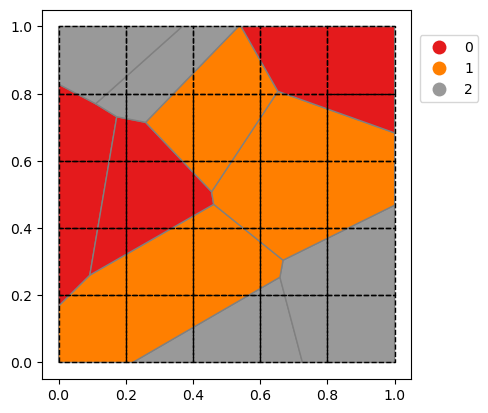

In [66]:
polygons = random_polygons(10, seed=7) # Use seed for reproducibility
print(polygons)

grid = lusos.LassoGrid(0, 0, 1, 1, 0.2, 0.2) # 5x5 grid between (0,0) and (1,1)
cells = grid_to_cells(grid.dataarray(), 0.2, 0.2)

fig, ax = plt.subplots()
polygons.plot(
    ax=ax,
    column='nr',
    edgecolor='grey',
    cmap='Set1',
    legend=True,
    categorical=True,
    legend_kwds={'bbox_to_anchor': (1.2, 0.95), 'loc': 'upper right'}
)
cells.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--')

The created GeoDataFrame contains 10 polygons belonging to one of three categories: 0, 1 or 2. Lusos calculates for each cell in a grid, in this case the 5x5 grid, the percentage of the cell that is covered by each category. The result will therefore be a 3D grid with the category as an extra dimension (lusos calls this dimension "layer"). The resulting grid will therefore be a 5x5x3 ("y", "x", "layer") grid with the percentage of each "layer" at every "y", "x" coordinate.

The first step of the calculation is the triangulation of the input polygons. Let's create the triangulation and unstructured grid and show what the result of the triangulation looks like.

<Axes: >

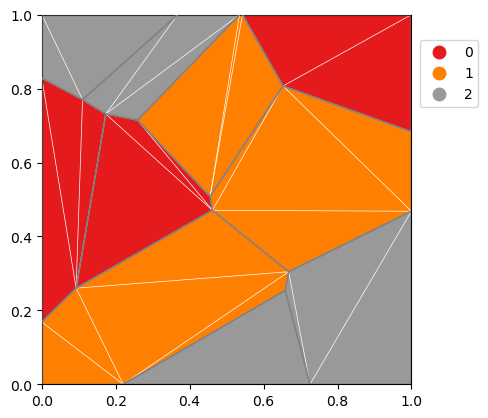

In [67]:
triangles, index, coords = lusos.ops.triangulate(polygons)
ugrid = xu.Ugrid2d(*coords.T, -1, triangles.astype("int32"))

fig, ax = plt.subplots()
polygons.plot(ax=ax, edgecolor='grey', facecolor='none', zorder=5) # plot outlines of polygons
ugrid.plot(ax=ax, color="w", linewidth=0.5, zorder=2)
polygons.plot(
    ax=ax,
    column='nr',
    cmap='Set1',
    legend=True,
    categorical=True,
    legend_kwds={'bbox_to_anchor': (1.2, 0.95), 'loc': 'upper right'}
)

Now that we have a basic understanding of the triangulation, we can calculate the overlapping areas of each polygon in each grid cell. The result is a namedtuple `PolygonGridArea` containing four different fields: `cell_idx`, `nitems`, `polygon` and `area`.

- `cell_idx` is a flat array with ordered indices of cells that have nonzero values (i.e. cell overlaps a polygon)
- `nitems` is a flat array that contains the number of polygons that overlap with each polygon
- `polygon` is the original row index in the GeoDataFrame of the polygon that overlaps with a cell
- `area` is the corresponding area.

In [68]:
area = lusos.ops.polygon_area_in_grid(polygons, grid.dataarray())
print(area)

PolygonGridArea(cell_idx=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]), nitems=array([ 5,  5,  6,  6,  2, 10,  7,  5,  5,  3,  4,  5, 10,  2,  5,  7,  3,
        5,  7,  3,  4,  5,  3,  4,  2]), polygon=array([7, 9, 9, 3, 3, 7, 7, 6, 7, 9, 8, 6, 6, 7, 7, 6, 8, 8, 5, 5, 5, 6,
       8, 8, 7, 7, 7, 9, 9, 4, 4, 3, 3, 3, 7, 7, 6, 4, 7, 4, 4, 5, 5, 6,
       6, 6, 8, 5, 5, 5, 6, 8, 5, 5, 4, 3, 3, 3, 6, 4, 2, 4, 4, 5, 5, 6,
       5, 6, 6, 4, 2, 4, 4, 5, 5, 5, 5, 5, 1, 1, 2, 4, 3, 3, 3, 2, 2, 2,
       4, 2, 5, 2, 2, 2, 0, 5, 1, 1, 2, 2, 2, 0, 5, 1, 1, 3, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1]), area=array([1.41629806e-03, 2.90067895e-02, 8.81955013e-03, 6.53842718e-05,
       6.91978086e-04, 4.94451402e-03, 1.42361908e-02, 1.77869302e-03,
       6.48457379e-03, 1.25560284e-02, 2.87168464e-03, 1.21155042e-02,
       1.27129541e-03, 2.64864843e-03, 6.75262556e-03, 1.43402417e-02,
       7.00978213e-03, 3.0

If we look below at the shapes of each array, we can see how the arrays relate to eachother. Note that cell_idx and nitems have the same shape and polygon and area. Looping over nitems we know how many elements we have to mask in polygon and area to get the result for a cell. By using the cell_idx we can than place the results at the correct location in a grid.

In [69]:
print(area.cell_idx.shape, area.nitems.shape, area.polygon.shape, area.area.shape)

(25,) (25,) (123,) (123,)


Remember that the values in `polygon` are the original row indices in the `polygons` GeoDataFrame so we can easily replace these indices with the "nr" of each polygon:

In [70]:
area.polygon[:] = polygons["nr"].values[area.polygon]
print(area)

PolygonGridArea(cell_idx=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]), nitems=array([ 5,  5,  6,  6,  2, 10,  7,  5,  5,  3,  4,  5, 10,  2,  5,  7,  3,
        5,  7,  3,  4,  5,  3,  4,  2]), polygon=array([2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]), area=array([1.41629806e-03, 2.90067895e-02, 8.81955013e-03, 6.53842718e-05,
       6.91978086e-04, 4.94451402e-03, 1.42361908e-02, 1.77869302e-03,
       6.48457379e-03, 1.25560284e-02, 2.87168464e-03, 1.21155042e-02,
       1.27129541e-03, 2.64864843e-03, 6.75262556e-03, 1.43402417e-02,
       7.00978213e-03, 3.0

Now we can translate the results back into a grid. Numpy arrays are row-major so we can derive the row and column index by using the number of columns of the 2D grid and the cell_idx and place the results at the correct location in a grid.

`row_idx, col_idx = np.divmod(cell_idx, ncols)`

As an example, we will show for the first two iterations how the arrays are related.

In [71]:
ncols_grid = 5  # Remember our grid is 5x5

min_idx = 0 # Mask always starts at 0
for i in range(2):
    row_idx, col_idx = np.divmod(area.cell_idx[i], ncols_grid)
    nitems = area.nitems[i]
    max_idx = min_idx + nitems

    p = area.polygon[min_idx:max_idx]
    a = area.area[min_idx:max_idx]

    print(f"{i=}: {row_idx=}, {col_idx=}, {nitems=}, {p=}, {a=}")
    min_idx += nitems

i=0: row_idx=np.int64(0), col_idx=np.int64(0), nitems=np.int64(5), p=array([2, 2, 2, 0, 0]), a=array([1.41629806e-03, 2.90067895e-02, 8.81955013e-03, 6.53842718e-05,
       6.91978086e-04])
i=1: row_idx=np.int64(0), col_idx=np.int64(1), nitems=np.int64(5), p=array([2, 2, 1, 2, 2]), a=array([0.00494451, 0.01423619, 0.00177869, 0.00648457, 0.01255603])


Now we can translate the namedtuple to a grid. The output will be a 3D grid ("y", "x", "layer") with for each cell, the percentage that is covered by each type of polygon.

In [72]:
units = polygons['nr'].unique()

cell_area = 0.2 * 0.2

area_grid = grid.empty_array(np.sort(units), dask=False)
area_grid.values = area_to_grid3d(area, area_grid.values)
area_grid = area_grid / cell_area
area_grid

<xarray.DataArray (y: 5, x: 5, layer: 3)> Size: 300B
array([[[0.01893406, 0.        , 0.9810659 ],
        [0.        , 0.04446733, 0.95553267],
        [0.07179212, 0.69317603, 0.23503186],
        [0.9283998 , 0.07160015, 0.        ],
        [1.        , 0.        , 0.        ]],

       [[0.85314524, 0.        , 0.1468548 ],
        [0.3333442 , 0.46171948, 0.20493636],
        [0.        , 1.        , 0.        ],
        [0.07266391, 0.9273361 , 0.        ],
        [0.40559384, 0.5944062 , 0.        ]],

       [[1.        , 0.        , 0.        ],
        [0.9586302 , 0.04136983, 0.        ],
        [0.12150949, 0.8784905 , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.882074  , 0.11792603]],

       [[0.71144146, 0.28855854, 0.        ],
        [0.13538493, 0.86461514, 0.        ],
        [0.        , 0.99135464, 0.00864541],
        [0.        , 0.4746812 , 0.5253188 ],
        [0.        , 0.02341674, 0.9765833 ]],

       [[0.01277437, 0.9872257 , 0.        ],
        [0.        , 0.7656194 , 0.23438063],
        [0.        , 0.198114  , 0.80188596],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ]]], dtype=float32)
Coordinates:
  * y        (y) float64 40B 0.9 0.7 0.5 0.3 0.1
  * x        (x) float64 40B 0.1 0.3 0.5 0.7 0.9
  * layer    (layer) int32 12B 0 1 2

Let's show the polygons again and for instance check the result of the center cell. This cell is covered by four different polygons with two unique "nrs": 0 and 1. We can see, approximately 12% of the cell is covered by nr 0 and approximately 88% is covered by nr 1 which is in agreement with the image.

<xarray.DataArray (layer: 3)> Size: 12B
array([0.12150949, 0.8784905 , 0.        ], dtype=float32)
Coordinates:
    y        float64 8B 0.5
    x        float64 8B 0.5
  * layer    (layer) int32 12B 0 1 2


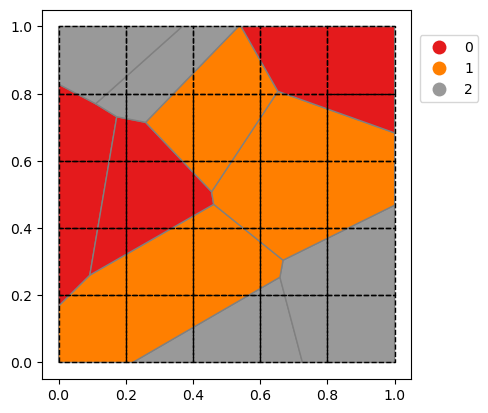

In [73]:
fig, ax = plt.subplots()
polygons.plot(
    ax=ax,
    column='nr',
    edgecolor='grey',
    cmap='Set1',
    legend=True,
    categorical=True,
    legend_kwds={'bbox_to_anchor': (1.2, 0.95), 'loc': 'upper right'}
)
cells.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--')
print(area_grid.sel(x=0.5, y=0.5, method='nearest'))